In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

In [6]:
csv_path = "weather_data.csv"
df = pd.read_csv(csv_path)

In [7]:
city = "New York"  # Change to your city of interest
df = df[df['Location'] == city]

# ----------- Data Cleaning -------------
df['Date_Time'] = pd.to_datetime(df['Date_Time'])
df = df.sort_values('Date_Time')


In [9]:
print (df)

        Location           Date_Time  Temperature_C  Humidity_pct  \
756040  New York 2024-01-01 00:04:45      37.991348     64.202440   
376731  New York 2024-01-01 00:04:52       8.191753     62.335497   
178214  New York 2024-01-01 00:04:55      26.772471     87.385380   
769287  New York 2024-01-01 00:08:07       9.503127     76.844316   
109092  New York 2024-01-01 00:09:15      37.375306     44.161119   
...          ...                 ...            ...           ...   
39585   New York 2024-05-18 19:24:37      14.096417     41.007459   
977600  New York 2024-05-18 19:27:32      19.017720     71.363038   
505621  New York 2024-05-18 19:29:20      39.699343     48.625874   
206025  New York 2024-05-18 19:42:40      37.953960     88.537128   
324735  New York 2024-05-18 19:43:55       7.679884     89.701606   

        Precipitation_mm  Wind_Speed_kmh  
756040          0.050219       24.157506  
376731          8.601657        0.612134  
178214          4.965877        8.243974  

In [19]:
df['Date'] = df['Date_Time'].dt.date
daily_df = df.groupby('Date').agg({
    'Temperature_C': 'mean',
    'Humidity_pct': 'mean',
    'Precipitation_mm': 'sum',
    'Wind_Speed_kmh': 'mean'
}).reset_index()
daily_df['Date'] = pd.to_datetime(daily_df['Date'])

In [20]:
dump(daily_df, 'cleaned_weather_data.joblib')

['cleaned_weather_data.joblib']

In [21]:
daily_df['Temp_MA7'] = daily_df['Temperature_C'].rolling(window=7).mean()
daily_df['Humidity_MA7'] = daily_df['Humidity_pct'].rolling(window=7).mean()
daily_df['Precipitation_MA7'] = daily_df['Precipitation_mm'].rolling(window=7).mean()


In [22]:
threshold = 2.0  # degrees Celsius deviation
anomalies = daily_df[
    (daily_df['Temperature_C'] - daily_df['Temp_MA7']).abs() > threshold
]

In [23]:
daily_df['Month'] = daily_df['Date'].dt.month
monthly_avg = daily_df.groupby('Month').mean()

In [24]:
print("\nSummary Statistics:\n", daily_df.describe())
print("\nCorrelation (excluding Date):\n", daily_df.drop(columns=['Date']).corr())



Summary Statistics:
                       Date  Temperature_C  Humidity_pct  Precipitation_mm  \
count                  139     139.000000    139.000000        139.000000   
mean   2024-03-10 00:00:00      15.015139     60.047724       3591.121205   
min    2024-01-01 00:00:00      13.505198     58.413868       3011.132281   
25%    2024-02-04 12:00:00      14.618613     59.635599       3485.973348   
50%    2024-03-10 00:00:00      14.987166     60.006257       3602.770723   
75%    2024-04-13 12:00:00      15.415657     60.436082       3692.516012   
max    2024-05-18 00:00:00      16.968038     61.414220       3900.211207   
std                    NaN       0.577942      0.613041        149.117567   

       Wind_Speed_kmh    Temp_MA7  Humidity_MA7  Precipitation_MA7       Month  
count      139.000000  133.000000    133.000000         133.000000  139.000000  
mean        14.988502   15.015396     60.036450        3597.177174    2.820144  
min         13.987183   14.655715     59.

In [34]:
max_temp = daily_df['Temperature_C'].max()
max_temp_date = daily_df.loc[daily_df['Temperature_C'].idxmax(), 'Date']

min_temp = daily_df['Temperature_C'].min()
min_temp_date = daily_df.loc[daily_df['Temperature_C'].idxmin(), 'Date']

max_precip = daily_df['Precipitation_mm'].max()
max_precip_date = daily_df.loc[daily_df['Precipitation_mm'].idxmax(), 'Date']

print(f"\nHighest temperature in {city} was {max_temp:.2f}°C on {max_temp_date.date()}")
print(f"Lowest temperature in {city} was {min_temp:.2f}°C on {min_temp_date.date()}")
print(f"Highest daily precipitation in {city} was {max_precip:.2f} mm on {max_precip_date.date()}")


Highest temperature in New York was 16.97°C on 2024-04-15
Lowest temperature in New York was 13.51°C on 2024-03-08
Highest daily precipitation in New York was 3900.21 mm on 2024-02-29



Average monthly weather stats:
       Temperature_C  Humidity_pct  Precipitation_mm
Month                                               
1          14.921598     60.095906       3572.875957
2          15.015370     60.100353       3619.891442
3          15.097284     60.077310       3586.035301
4          15.002798     59.987753       3595.607338
5          15.054958     59.928953       3577.473697


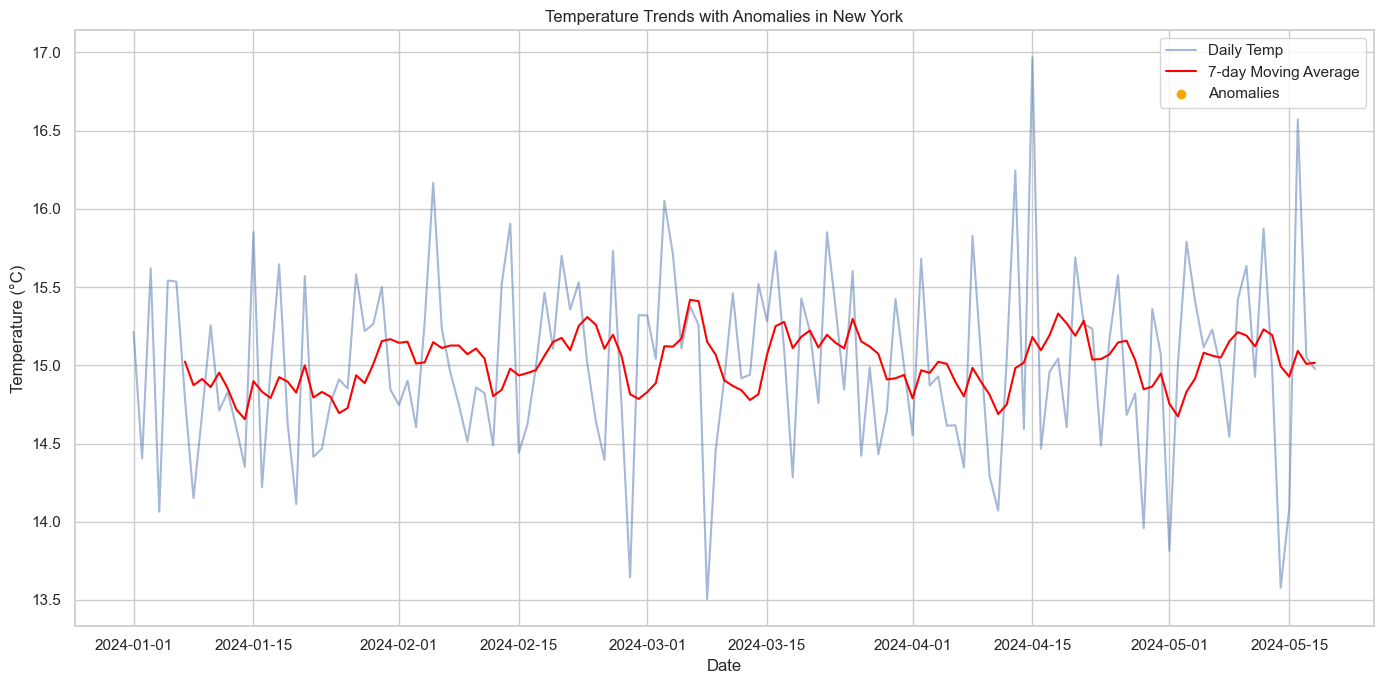

In [28]:
print("\nAverage monthly weather stats:")
print(monthly_avg[['Temperature_C', 'Humidity_pct', 'Precipitation_mm']])

# ----------- Plotting -------------
sns.set(style="whitegrid")

# Temperature with Moving Average and Anomalies
plt.figure(figsize=(14, 7))
plt.plot(daily_df['Date'], daily_df['Temperature_C'], label='Daily Temp', alpha=0.5)
plt.plot(daily_df['Date'], daily_df['Temp_MA7'], label='7-day Moving Average', color='red')
plt.scatter(anomalies['Date'], anomalies['Temperature_C'], color='orange', label='Anomalies', zorder=5)
plt.title(f"Temperature Trends with Anomalies in {city}")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.show()

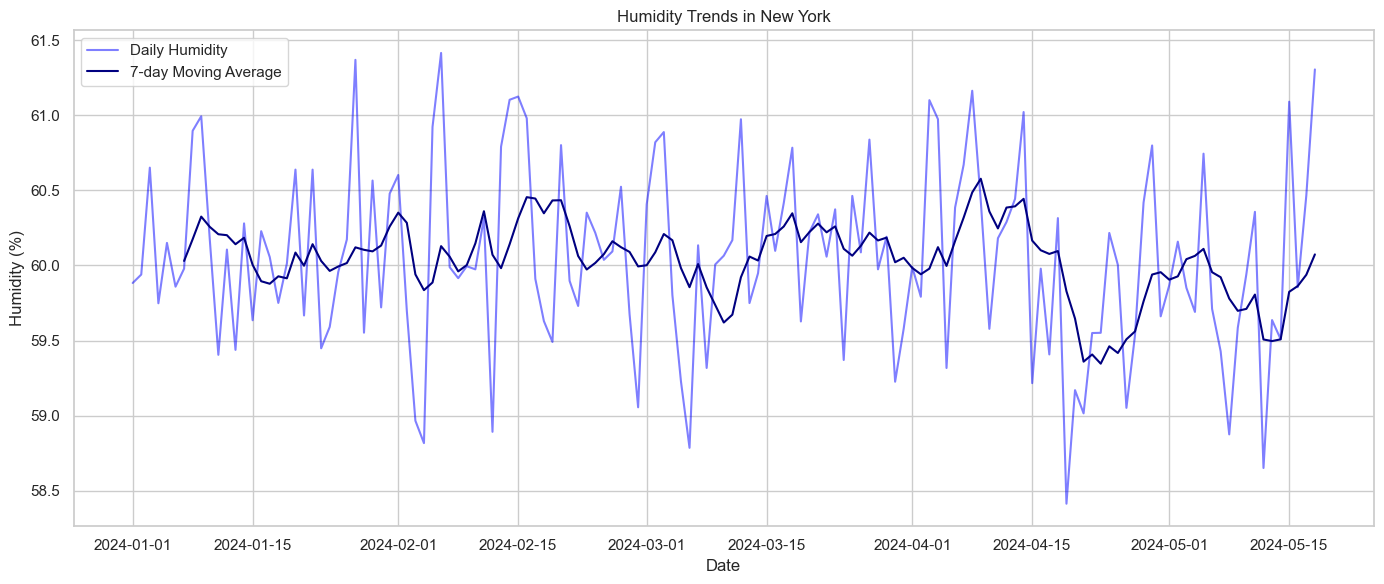

In [29]:
# Humidity with Moving Average
plt.figure(figsize=(14, 6))
plt.plot(daily_df['Date'], daily_df['Humidity_pct'], label='Daily Humidity', alpha=0.5, color='blue')
plt.plot(daily_df['Date'], daily_df['Humidity_MA7'], label='7-day Moving Average', color='navy')
plt.title(f"Humidity Trends in {city}")
plt.xlabel("Date")
plt.ylabel("Humidity (%)")
plt.legend()
plt.tight_layout()
plt.show()

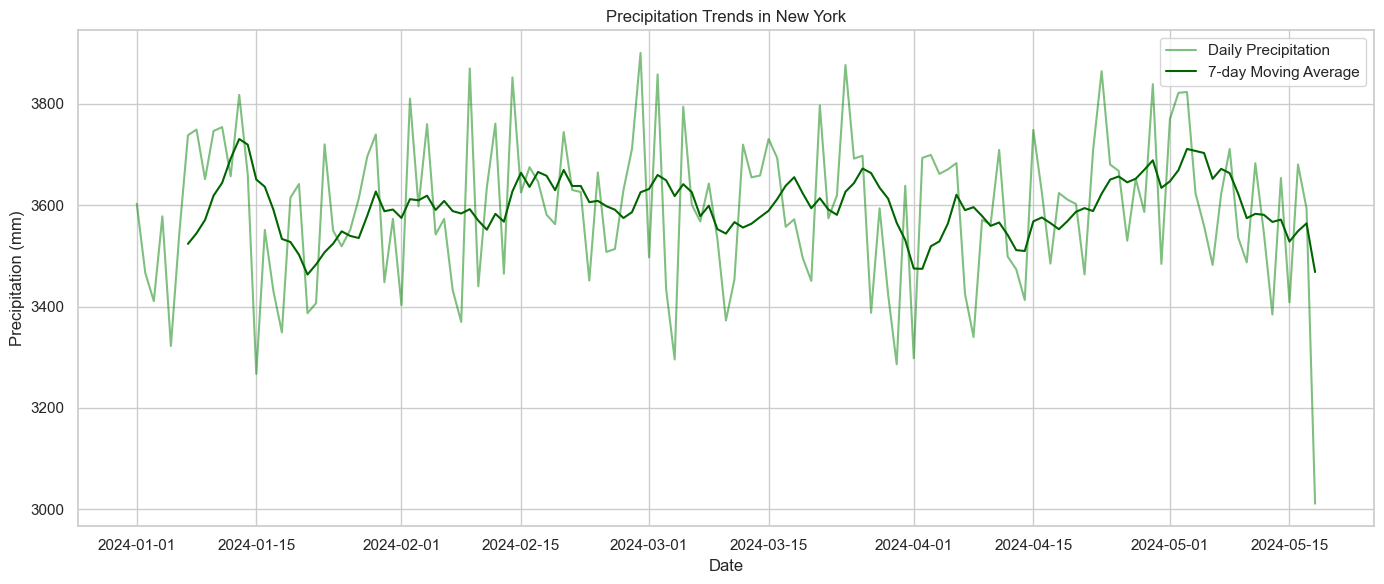

In [30]:
# Precipitation with Moving Average
plt.figure(figsize=(14, 6))
plt.plot(daily_df['Date'], daily_df['Precipitation_mm'], label='Daily Precipitation', alpha=0.5, color='green')
plt.plot(daily_df['Date'], daily_df['Precipitation_MA7'], label='7-day Moving Average', color='darkgreen')
plt.title(f"Precipitation Trends in {city}")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

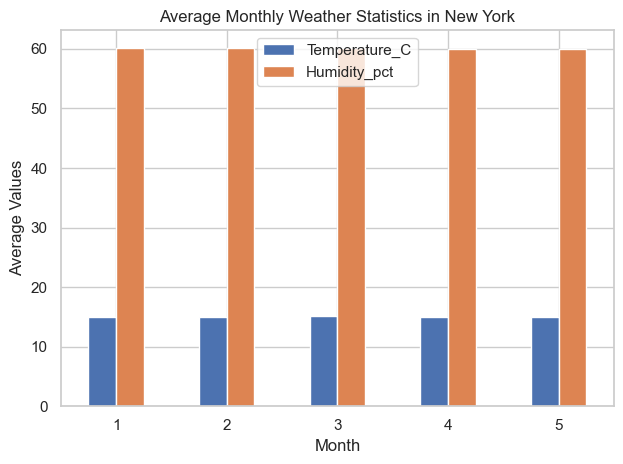

In [32]:
# Monthly Averages Bar Plot
plt.figure(figsize=(12, 6))
monthly_avg[['Temperature_C', 'Humidity_pct']].plot(kind='bar')
plt.title(f"Average Monthly Weather Statistics in {city}")
plt.xlabel("Month")
plt.ylabel("Average Values")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()